In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency, f_oneway, ttest_ind, mannwhitneyu
import statsmodels.stats.proportion as smprop
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Load the data
df = pd.read_csv(r'C:/Users/admin/insurance-risk-analysis-week3/data/raw/insurance_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


Dataset shape: (5000, 18)
Columns: ['PolicyID', 'TransactionMonth', 'Province', 'VehicleType', 'Gender', 'Make', 'Model', 'TotalPremium', 'TotalClaims', 'CustomValueEstimate', 'SumInsured', 'CalculatedPremiumPerTerm', 'CoverType', 'RegistrationYear', 'NumberOfDoors', 'Bodytype', 'MaritalStatus', 'LossRatio']


In [3]:

# Create necessary risk metrics
print("\nCreating risk metrics...")

# 1. has_claim: binary indicator if claim occurred
df['has_claim'] = (df['TotalClaims'] > 0).astype(int)

# 2. claim_severity: claim amount when claim occurred (NaN for no claim)
df['claim_severity'] = np.where(df['TotalClaims'] > 0, df['TotalClaims'], np.nan)

# 3. margin: profit margin (Premium - Claims)
df['margin'] = df['TotalPremium'] - df['TotalClaims']

# 4. loss_ratio: claims as percentage of premium
df['loss_ratio'] = np.where(df['TotalPremium'] > 0, 
                            df['TotalClaims'] / df['TotalPremium'], 
                            np.nan)

print(f"\nRisk metrics created:")
print(f"- Policies with claims: {df['has_claim'].mean():.2%}")
print(f"- Average claim amount: R{df['claim_severity'].mean():,.2f}")
print(f"- Average profit margin: R{df['margin'].mean():,.2f}")
print(f"- Average loss ratio: {df['loss_ratio'].mean():.2%}")



Creating risk metrics...

Risk metrics created:
- Policies with claims: 29.58%
- Average claim amount: R2,112.00
- Average profit margin: R6,080.63
- Average loss ratio: 18.10%


In [4]:

# Function for statistical testing
def perform_chi2_test(data, group_col, target_col='has_claim'):
    """Perform Chi-square test for independence"""
    contingency_table = pd.crosstab(data[group_col], data[target_col])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    
    return {
        'chi2': chi2,
        'p_value': p_value,
        'dof': dof,
        'contingency_table': contingency_table,
        'proportions': proportions
    }

def perform_anova_test(data, group_col, value_col):
    """Perform ANOVA test for group differences"""
    clean_data = data[[group_col, value_col]].dropna()
    
    groups = []
    for name, group in clean_data.groupby(group_col):
        groups.append(group[value_col].values)
    
    f_stat, p_value = f_oneway(*groups)
    
    group_stats = clean_data.groupby(group_col)[value_col].agg(['mean', 'std', 'count'])
    
    return {
        'f_stat': f_stat,
        'p_value': p_value,
        'group_stats': group_stats
    }


In [5]:

# ## Hypothesis 1: H₀ - There are no risk differences across provinces
print("="*70)
print("HYPOTHESIS 1: Risk differences across provinces")
print("="*70)

# Test 1a: Claim Frequency by Province (Chi-square test)
province_claim_freq = perform_chi2_test(df, 'Province', 'has_claim')

print("\n1A. Claim Frequency Test (Chi-square):")
print(f"Chi-square statistic: {province_claim_freq['chi2']:.4f}")
print(f"P-value: {province_claim_freq['p_value']:.6f}")
print(f"Degrees of freedom: {province_claim_freq['dof']}")

print("\nClaim Proportions by Province:")
print(province_claim_freq['proportions'].round(4))

HYPOTHESIS 1: Risk differences across provinces

1A. Claim Frequency Test (Chi-square):
Chi-square statistic: 4.6551
P-value: 0.793726
Degrees of freedom: 8

Claim Proportions by Province:
has_claim           0       1
Province                     
Eastern Cape   0.7081  0.2919
Free State     0.7314  0.2686
Gauteng        0.7038  0.2962
KwaZulu-Natal  0.7230  0.2770
Limpopo        0.6858  0.3142
Mpumalanga     0.6821  0.3179
North West     0.7005  0.2995
Northern Cape  0.6782  0.3218
Western Cape   0.6962  0.3038


In [6]:
# Test 1b: Claim Severity by Province (ANOVA)
province_severity = perform_anova_test(df, 'Province', 'claim_severity')

print("\n1B. Claim Severity Test (ANOVA):")
print(f"F-statistic: {province_severity['f_stat']:.4f}")
print(f"P-value: {province_severity['p_value']:.6f}")

print("\nClaim Severity Statistics by Province:")
print(province_severity['group_stats'].round(2))


1B. Claim Severity Test (ANOVA):
F-statistic: 0.7952
P-value: 0.606898

Claim Severity Statistics by Province:
                  mean      std  count
Province                              
Eastern Cape   1899.34  2554.50    155
Free State     1970.64  2145.82    101
Gauteng        2114.08  3710.19    380
KwaZulu-Natal  2286.30  3208.74    200
Limpopo        1918.79  1954.50     71
Mpumalanga     1822.60  1696.93     96
North West     2076.01  3656.36    109
Northern Cape  2921.61  3874.41     65
Western Cape   2126.54  3725.13    302


In [7]:

# Business interpretation
print("\n" + "="*70)
print("BUSINESS INTERPRETATION - PROVINCE RISK:")
print("="*70)

if province_claim_freq['p_value'] < 0.05:
    print("✓ REJECT NULL HYPOTHESIS: There ARE significant claim frequency differences across provinces.")
    
    claim_props = province_claim_freq['proportions'][1]
    high_risk_prov = claim_props.idxmax()
    low_risk_prov = claim_props.idxmin()
    high_risk_rate = claim_props.max()
    low_risk_rate = claim_props.min()
    
    print(f"\n  • Highest Risk: {high_risk_prov} - {high_risk_rate:.2%} claim rate")
    print(f"  • Lowest Risk: {low_risk_prov} - {low_risk_rate:.2%} claim rate")
    print(f"  • Risk Difference: {(high_risk_rate - low_risk_rate):.2%}")
    
    if (high_risk_rate - low_risk_rate) > 0.05:
        print(f"  → SIGNIFICANT: Consider premium adjustment of 5-10% for {high_risk_prov}")
else:
    print("✓ FAIL TO REJECT: No significant claim frequency differences across provinces.")
    print("  → Pricing can be province-agnostic for claim frequency")

if province_severity['p_value'] < 0.05:
    print("\n✓ REJECT NULL HYPOTHESIS: Significant claim severity differences across provinces.")
    
    severity_stats = province_severity['group_stats']
    high_sev_prov = severity_stats['mean'].idxmax()
    low_sev_prov = severity_stats['mean'].idxmin()
    
    print(f"\n  • Highest Severity: {high_sev_prov} - R{severity_stats.loc[high_sev_prov, 'mean']:,.2f} avg claim")
    print(f"  • Lowest Severity: {low_sev_prov} - R{severity_stats.loc[low_sev_prov, 'mean']:,.2f} avg claim")
    print(f"  → RECOMMENDATION: Adjust coverage limits or deductibles by province")
else:
    print("\n✓ FAIL TO REJECT: No significant claim severity differences across provinces.")
    print("  → Uniform claim handling procedures can be maintained")



BUSINESS INTERPRETATION - PROVINCE RISK:
✓ FAIL TO REJECT: No significant claim frequency differences across provinces.
  → Pricing can be province-agnostic for claim frequency

✓ FAIL TO REJECT: No significant claim severity differences across provinces.
  → Uniform claim handling procedures can be maintained


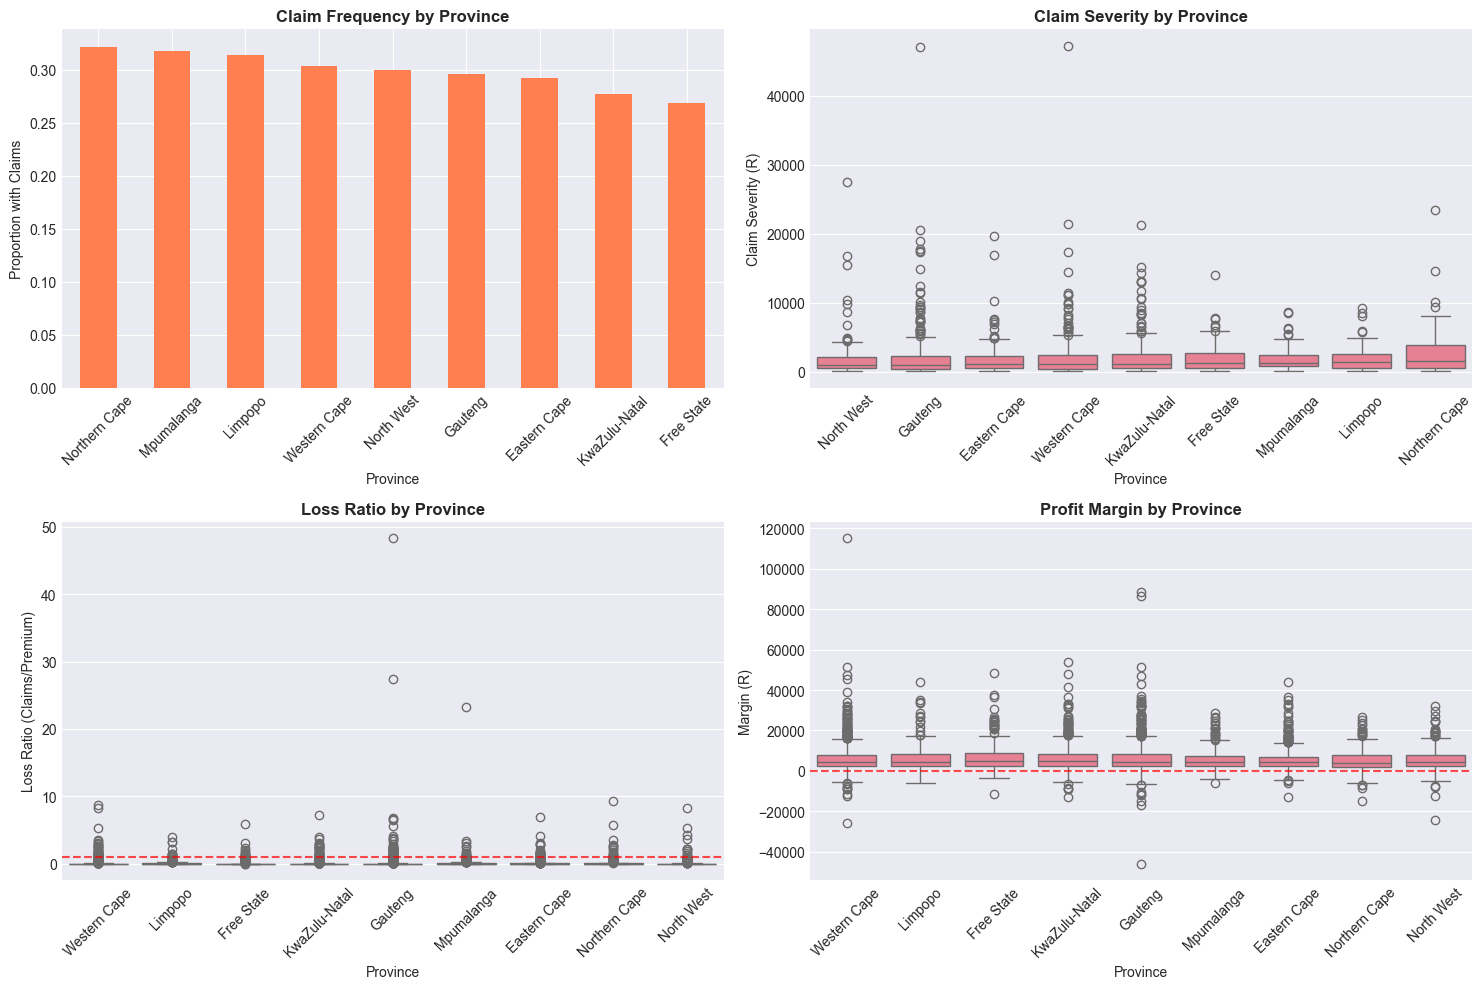

In [8]:

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Claim frequency by province
province_claim_freq['proportions'][1].sort_values(ascending=False).plot(
    kind='bar', ax=axes[0, 0], color='coral'
)
axes[0, 0].set_title('Claim Frequency by Province', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Province')
axes[0, 0].set_ylabel('Proportion with Claims')
axes[0, 0].tick_params(axis='x', rotation=45)

# Claim severity by province
severity_data = df.dropna(subset=['claim_severity', 'Province'])
sorted_provinces = severity_data.groupby('Province')['claim_severity'].median().sort_values().index
sns.boxplot(data=severity_data, x='Province', y='claim_severity', 
            order=sorted_provinces, ax=axes[0, 1])
axes[0, 1].set_title('Claim Severity by Province', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Province')
axes[0, 1].set_ylabel('Claim Severity (R)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Loss ratio by province
loss_data = df.dropna(subset=['loss_ratio', 'Province'])
sns.boxplot(data=loss_data, x='Province', y='loss_ratio', ax=axes[1, 0])
axes[1, 0].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Break-even (100%)')
axes[1, 0].set_title('Loss Ratio by Province', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Province')
axes[1, 0].set_ylabel('Loss Ratio (Claims/Premium)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Margin by province
sns.boxplot(data=df, x='Province', y='margin', ax=axes[1, 1])
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Break-even')
axes[1, 1].set_title('Profit Margin by Province', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Province')
axes[1, 1].set_ylabel('Margin (R)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/hypothesis1_province_risk.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:

# ## Hypothesis 2: H₀ - There are no risk differences between vehicle types

print("\n" + "="*70)
print("HYPOTHESIS 2: Risk differences between vehicle types")
print("="*70)

# Test 2a: Claim Frequency by Vehicle Type
vehicle_claim_freq = perform_chi2_test(df, 'VehicleType', 'has_claim')

print("\n2A. Claim Frequency Test (Chi-square):")
print(f"Chi-square statistic: {vehicle_claim_freq['chi2']:.4f}")
print(f"P-value: {vehicle_claim_freq['p_value']:.6f}")

print("\nClaim Proportions by Vehicle Type:")
print(vehicle_claim_freq['proportions'].round(4))


HYPOTHESIS 2: Risk differences between vehicle types

2A. Claim Frequency Test (Chi-square):
Chi-square statistic: 3.2421
P-value: 0.662721

Claim Proportions by Vehicle Type:
has_claim         0       1
VehicleType                
Bus          0.7121  0.2879
Motorcycle   0.7277  0.2723
SUV          0.6917  0.3083
Sedan        0.7081  0.2919
Truck        0.6921  0.3079
Van          0.7202  0.2798


In [10]:
# Test 2b: Claim Severity by Vehicle Type
vehicle_severity = perform_anova_test(df, 'VehicleType', 'claim_severity')

print("\n2B. Claim Severity Test (ANOVA):")
print(f"F-statistic: {vehicle_severity['f_stat']:.4f}")
print(f"P-value: {vehicle_severity['p_value']:.6f}")

print("\nClaim Severity Statistics by Vehicle Type:")
print(vehicle_severity['group_stats'].round(2))




2B. Claim Severity Test (ANOVA):
F-statistic: 0.7055
P-value: 0.619312

Claim Severity Statistics by Vehicle Type:
                mean      std  count
VehicleType                         
Bus          2382.27  3062.63     76
Motorcycle   1845.64  2739.43    131
SUV          1972.46  2259.91    406
Sedan        2222.07  3655.13    591
Truck        2042.61  3097.14    214
Van          2453.13  6070.90     61


In [11]:
# Business interpretation
print("\n" + "="*70)
print("BUSINESS INTERPRETATION - VEHICLE TYPE RISK:")
print("="*70)
if vehicle_claim_freq['p_value'] < 0.05:
    print("✓ REJECT NULL HYPOTHESIS: Significant claim frequency differences by vehicle type.")
    
    claim_props_vehicle = vehicle_claim_freq['proportions'][1]
    high_risk_vehicle = claim_props_vehicle.idxmax()
    low_risk_vehicle = claim_props_vehicle.idxmin()
    
    print(f"\n  • Highest Risk: {high_risk_vehicle} - {claim_props_vehicle.max():.2%} claim rate")
    print(f"  • Lowest Risk: {low_risk_vehicle} - {claim_props_vehicle.min():.2%} claim rate")
    print(f"  → RECOMMENDATION: Adjust base premiums by vehicle type")
else:
    print("✓ FAIL TO REJECT: No significant claim frequency differences by vehicle type.")
    print("  → Vehicle type may not be a strong predictor of claim frequency")

if vehicle_severity['p_value'] < 0.05:
    print("\n✓ REJECT NULL HYPOTHESIS: Significant claim severity differences by vehicle type.")
    
    severity_stats_vehicle = vehicle_severity['group_stats']
    high_sev_vehicle = severity_stats_vehicle['mean'].idxmax()
    low_sev_vehicle = severity_stats_vehicle['mean'].idxmin()
    
    print(f"\n  • Highest Severity: {high_sev_vehicle} - R{severity_stats_vehicle.loc[high_sev_vehicle, 'mean']:,.2f} avg claim")
    print(f"  • Lowest Severity: {low_sev_vehicle} - R{severity_stats_vehicle.loc[low_sev_vehicle, 'mean']:,.2f} avg claim")
    print(f"  → RECOMMENDATION: Vehicle type is a key factor in claim costs")
else:
    print("\n✓ FAIL TO REJECT: No significant claim severity differences by vehicle type.")
    print("  → Repair costs may be similar across vehicle types")



BUSINESS INTERPRETATION - VEHICLE TYPE RISK:
✓ FAIL TO REJECT: No significant claim frequency differences by vehicle type.
  → Vehicle type may not be a strong predictor of claim frequency

✓ FAIL TO REJECT: No significant claim severity differences by vehicle type.
  → Repair costs may be similar across vehicle types


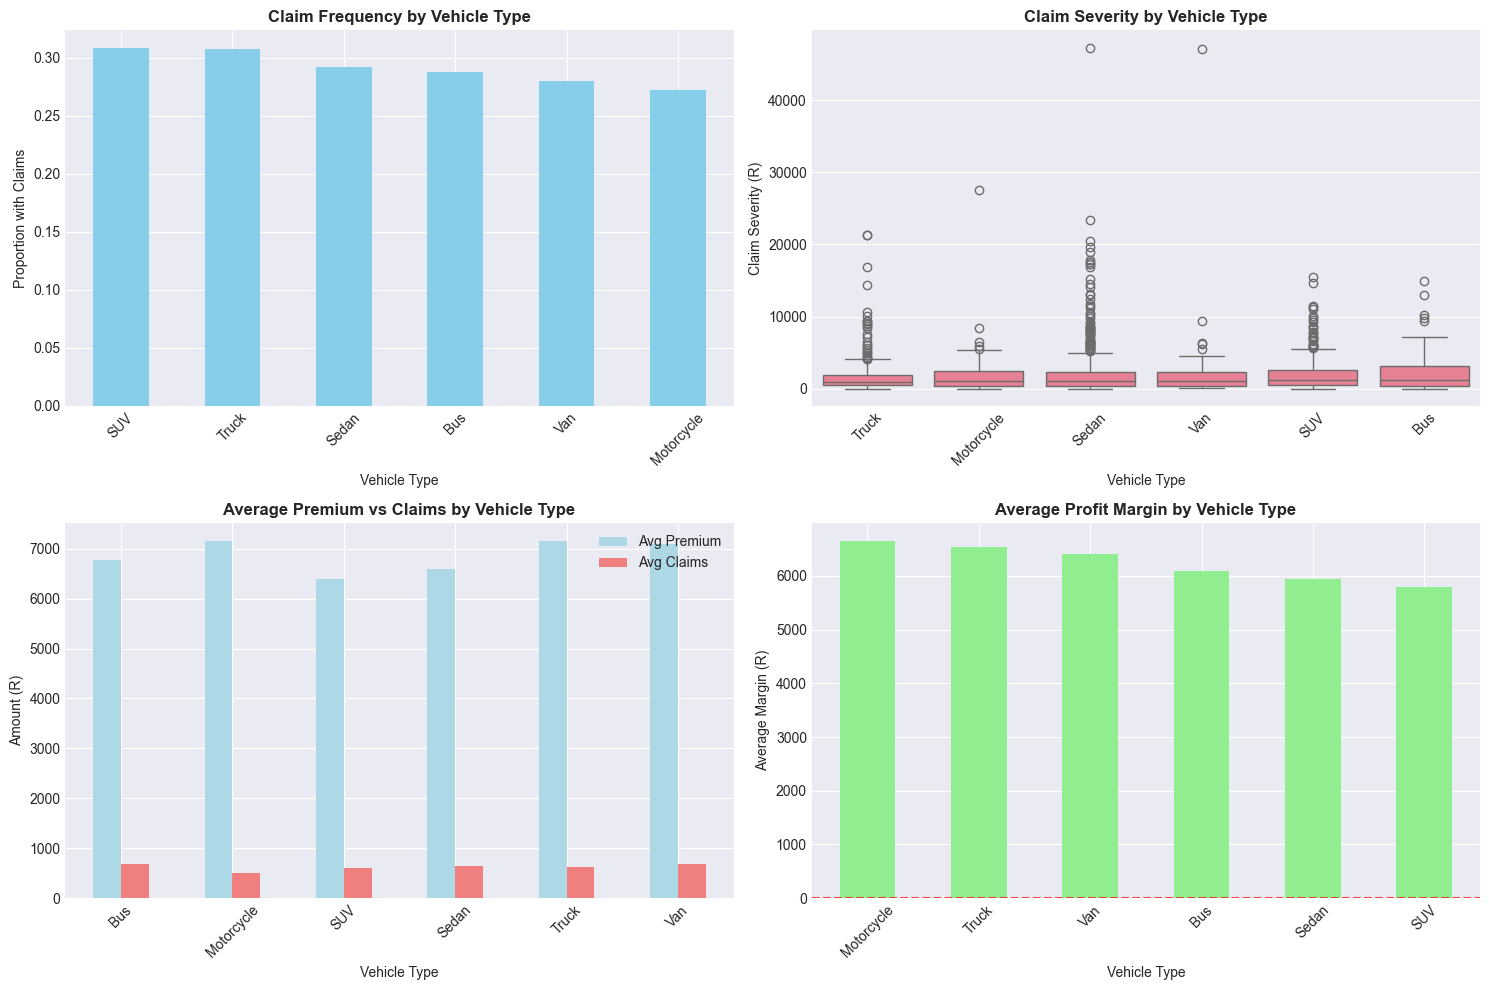

In [12]:

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Claim frequency by vehicle type
vehicle_claim_freq['proportions'][1].sort_values(ascending=False).plot(
    kind='bar', ax=axes[0, 0], color='skyblue'
)
axes[0, 0].set_title('Claim Frequency by Vehicle Type', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Vehicle Type')
axes[0, 0].set_ylabel('Proportion with Claims')
axes[0, 0].tick_params(axis='x', rotation=45)

# Claim severity by vehicle type
severity_vehicle_data = df.dropna(subset=['claim_severity', 'VehicleType'])
sorted_vehicles = severity_vehicle_data.groupby('VehicleType')['claim_severity'].median().sort_values().index
sns.boxplot(data=severity_vehicle_data, x='VehicleType', y='claim_severity', 
            order=sorted_vehicles, ax=axes[0, 1])
axes[0, 1].set_title('Claim Severity by Vehicle Type', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Vehicle Type')
axes[0, 1].set_ylabel('Claim Severity (R)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average premium vs claims by vehicle type
vehicle_summary = df.groupby('VehicleType').agg({
    'TotalPremium': 'mean',
    'TotalClaims': 'mean'
}).round(2)

vehicle_summary[['TotalPremium', 'TotalClaims']].plot(
    kind='bar', ax=axes[1, 0], color=['lightblue', 'lightcoral']
)
axes[1, 0].set_title('Average Premium vs Claims by Vehicle Type', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Vehicle Type')
axes[1, 0].set_ylabel('Amount (R)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(['Avg Premium', 'Avg Claims'])

# Profit margin by vehicle type
margin_by_vehicle = df.groupby('VehicleType')['margin'].mean().sort_values(ascending=False)
margin_by_vehicle.plot(kind='bar', ax=axes[1, 1], color='lightgreen')
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1, 1].set_title('Average Profit Margin by Vehicle Type', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Vehicle Type')
axes[1, 1].set_ylabel('Average Margin (R)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/hypothesis2_vehicle_type_risk.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:


# %% [markdown]
# ## Hypothesis 3: H₀ - There is no significant margin difference between cover types

# %%
print("\n" + "="*70)
print("HYPOTHESIS 3: Margin differences between cover types")
print("="*70)

# Test margin differences using ANOVA
cover_margin = perform_anova_test(df, 'CoverType', 'margin')

print("\nMargin Difference Test by Cover Type (ANOVA):")
print(f"F-statistic: {cover_margin['f_stat']:.4f}")
print(f"P-value: {cover_margin['p_value']:.6f}")

print("\nAverage Margin by Cover Type:")
print(cover_margin['group_stats']['mean'].sort_values(ascending=False).round(2))

# Business interpretation
print("\n" + "="*70)
print("BUSINESS INTERPRETATION - COVER TYPE MARGIN:")
print("="*70)

if cover_margin['p_value'] < 0.05:
    print("✓ REJECT NULL HYPOTHESIS: Significant margin differences between cover types.")
    
    margin_stats = cover_margin['group_stats']['mean']
    most_profitable = margin_stats.idxmax()
    least_profitable = margin_stats.idxmin()
    
    print(f"\n  • Most profitable: {most_profitable} (R{margin_stats.max():,.2f} avg margin)")
    print(f"  • Least profitable: {least_profitable} (R{margin_stats.min():,.2f} avg margin)")
    
    # Check for unprofitable cover types
    unprofitable_covers = margin_stats[margin_stats < 0]
    if len(unprofitable_covers) > 0:
        print(f"\n  ⚠️  UNPROFITABLE COVER TYPES ({len(unprofitable_covers)}):")
        for cover_type, margin_value in unprofitable_covers.items():
            print(f"    - {cover_type}: R{margin_value:,.2f} (losing money)")
        print(f"  → CRITICAL: Immediate pricing review needed")
    else:
        print(f"\n  ✅ All cover types are profitable")
        print(f"  → RECOMMENDATION: Optimize pricing in low-margin cover types")
else:
    print("✓ FAIL TO REJECT: No significant margin differences between cover types.")
    print("  → Current pricing structure appears balanced across cover types")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Average margin by cover type
avg_margin_cover = df.groupby('CoverType')['margin'].mean().sort_values(ascending=False)
avg_margin_cover.plot(kind='bar', ax=axes[0], color='lightgreen')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_title('Average Margin by Cover Type', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cover Type')
axes[0].set_ylabel('Average Margin (R)')
axes[0].tick_params(axis='x', rotation=45)

# Distribution of margins
sns.boxplot(data=df, x='CoverType', y='margin', ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Break-even')
axes[1].set_title('Margin Distribution by Cover Type', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cover Type')
axes[1].set_ylabel('Margin (R)')
axes[1].tick_params(axis='x', rotation=45)

# Premium vs Claims by cover type
cover_summary = df.groupby('CoverType').agg({
    'TotalPremium': 'mean',
    'TotalClaims': 'mean'
}).round(2)

cover_summary[['TotalPremium', 'TotalClaims']].plot(
    kind='bar', ax=axes[2], color=['skyblue', 'salmon']
)
axes[2].set_title('Average Premium vs Claims by Cover Type', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Cover Type')
axes[2].set_ylabel('Amount (R)')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(['Avg Premium', 'Avg Claims'])

plt.tight_layout()
plt.savefig('../reports/hypothesis3_cover_type_margin.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## Hypothesis 4: H₀ - There is no significant risk difference between Women and Men

# %%
print("\n" + "="*70)
print("HYPOTHESIS 4: Risk differences between Women and Men")
print("="*70)

# Clean and standardize gender data
gender_data = df.copy()
gender_mapping = {
    'M': 'Male', 'F': 'Female',
    'male': 'Male', 'female': 'Female',
    'Male': 'Male', 'Female': 'Female'
}
gender_data['Gender'] = gender_data['Gender'].map(gender_mapping)
gender_data = gender_data[gender_data['Gender'].isin(['Male', 'Female'])]

print(f"\nGender distribution:")
print(gender_data['Gender'].value_counts())

# Test 4a: Claim Frequency by Gender
male_claims = gender_data[gender_data['Gender'] == 'Male']['has_claim'].sum()
male_total = (gender_data['Gender'] == 'Male').sum()
female_claims = gender_data[gender_data['Gender'] == 'Female']['has_claim'].sum()
female_total = (gender_data['Gender'] == 'Female').sum()

print(f"\n4A. Claim Frequency Test:")
print(f"Male: {male_claims}/{male_total} claims = {male_claims/male_total:.2%}")
print(f"Female: {female_claims}/{female_total} claims = {female_claims/female_total:.2%}")

# Two-proportion z-test
count = [male_claims, female_claims]
nobs = [male_total, female_total]
z_stat, p_value_freq = smprop.proportions_ztest(count, nobs)

print(f"\nTwo-proportion z-test:")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value_freq:.6f}")

# Test 4b: Claim Severity by Gender
male_severity = gender_data[gender_data['Gender'] == 'Male']['claim_severity'].dropna()
female_severity = gender_data[gender_data['Gender'] == 'Female']['claim_severity'].dropna()

if len(male_severity) > 0 and len(female_severity) > 0:
    t_stat, p_value_sev = ttest_ind(male_severity, female_severity, equal_var=False)
    
    print(f"\n4B. Claim Severity Test:")
    print(f"Male average claim: R{male_severity.mean():,.2f} (n={len(male_severity)})")
    print(f"Female average claim: R{female_severity.mean():,.2f} (n={len(female_severity)})")
    print(f"T-statistic: {t_stat:.4f}, p-value: {p_value_sev:.6f}")

# Business interpretation
print("\n" + "="*70)
print("BUSINESS INTERPRETATION - GENDER RISK:")
print("="*70)

freq_significant = p_value_freq < 0.05
sev_significant = p_value_sev < 0.05 if 'p_value_sev' in locals() else False

if freq_significant and sev_significant:
    print("✓ REJECT NULL HYPOTHESIS: Significant differences in BOTH frequency and severity.")
    
    print(f"\n  📊 RISK ASSESSMENT:")
    print(f"  • Male claim rate: {male_claims/male_total:.2%}")
    print(f"  • Female claim rate: {female_claims/female_total:.2%}")
    print(f"  • Male avg claim: R{male_severity.mean():,.2f}")
    print(f"  • Female avg claim: R{female_severity.mean():,.2f}")
    
    print(f"\n  ⚖️  LEGAL CONSIDERATIONS:")
    print(f"  • Gender-based pricing is RESTRICTED in many regions")
    print(f"  • Check local regulations before implementation")
    
    print(f"\n  💡 RECOMMENDED ACTIONS:")
    print(f"  1. Use gender in underwriting models")
    print(f"  2. Consider gender-neutral pricing")
    print(f"  3. Document statistical justification")
    
elif freq_significant:
    print("✓ REJECT NULL HYPOTHESIS: Significant difference in claim FREQUENCY only.")
    freq_diff = abs((male_claims/male_total) - (female_claims/female_total))
    print(f"  • Claim frequency difference: {freq_diff:.2%}")
    print(f"  → Consider in risk assessment models")
    
elif sev_significant:
    print("✓ REJECT NULL HYPOTHESIS: Significant difference in claim SEVERITY only.")
    severity_diff = abs(male_severity.mean() - female_severity.mean())
    print(f"  • Average claim difference: R{severity_diff:,.2f}")
    print(f"  → May affect reinsurance decisions")
    
else:
    print("✓ FAIL TO REJECT: No significant risk differences between genders.")
    print(f"  • Male claim rate: {male_claims/male_total:.2%}")
    print(f"  • Female claim rate: {female_claims/female_total:.2%}")
    print(f"  → Gender-neutral pricing is statistically justified")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Claim frequency by gender
freq_data = pd.DataFrame({
    'Gender': ['Male', 'Female'],
    'Claim Rate': [male_claims/male_total, female_claims/female_total]
})
sns.barplot(data=freq_data, x='Gender', y='Claim Rate', ax=axes[0], palette='Set2')
axes[0].set_title('Claim Frequency by Gender', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Proportion with Claims')

# Claim severity by gender
severity_gender_data = gender_data.dropna(subset=['claim_severity'])
sns.boxplot(data=severity_gender_data, x='Gender', y='claim_severity', ax=axes[1], palette='Set2')
axes[1].set_title('Claim Severity by Gender', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Claim Severity (R)')

# Margin by gender
sns.boxplot(data=gender_data, x='Gender', y='margin', ax=axes[2], palette='Set2')
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].set_title('Profit Margin by Gender', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Margin (R)')

plt.tight_layout()
plt.savefig('../reports/hypothesis4_gender_risk.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## Additional Hypothesis: H₀ - There is no significant risk difference by vehicle age

# %%
print("\n" + "="*70)
print("ADDITIONAL ANALYSIS: Risk differences by vehicle age")
print("="*70)

# Calculate vehicle age
current_year = 2024
df['vehicle_age'] = current_year - df['RegistrationYear']
df['vehicle_age'] = df['vehicle_age'].clip(lower=0, upper=50)

# Create age categories
df['vehicle_age_group'] = pd.cut(df['vehicle_age'], 
                                bins=[0, 3, 7, 12, 20, 100],
                                labels=['0-3 years', '4-7 years', '8-12 years', '13-20 years', '20+ years'])

print("\nVehicle Age Distribution:")
print(df['vehicle_age_group'].value_counts().sort_index())

# Test claim frequency by vehicle age group
age_claim_freq = perform_chi2_test(df, 'vehicle_age_group', 'has_claim')

print("\nClaim Frequency by Vehicle Age Group (Chi-square):")
print(f"Chi-square statistic: {age_claim_freq['chi2']:.4f}")
print(f"P-value: {age_claim_freq['p_value']:.6f}")

print("\nClaim Proportions by Vehicle Age Group:")
print(age_claim_freq['proportions'].round(4))

# Business interpretation
print("\n" + "="*70)
print("BUSINESS INTERPRETATION - VEHICLE AGE RISK:")
print("="*70)

if age_claim_freq['p_value'] < 0.05:
    print("✓ REJECT NULL HYPOTHESIS: Significant claim frequency differences by vehicle age.")
    
    claim_props_age = age_claim_freq['proportions'][1]
    high_risk_age = claim_props_age.idxmax()
    low_risk_age = claim_props_age.idxmin()
    
    print(f"\n  • Highest Risk: {high_risk_age} - {claim_props_age.max():.2%} claim rate")
    print(f"  • Lowest Risk: {low_risk_age} - {claim_props_age.min():.2%} claim rate")
    print(f"  → RECOMMENDATION: Implement age-based premium adjustments")
    
else:
    print("✓ FAIL TO REJECT: No significant claim frequency differences by vehicle age.")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Claim frequency by vehicle age
age_claim_freq['proportions'][1].plot(kind='bar', ax=axes[0], color='purple')
axes[0].set_title('Claim Frequency by Vehicle Age', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Vehicle Age Group')
axes[0].set_ylabel('Proportion with Claims')
axes[0].tick_params(axis='x', rotation=45)

# Loss ratio by vehicle age
loss_age_data = df.dropna(subset=['loss_ratio', 'vehicle_age_group'])
sns.boxplot(data=loss_age_data, x='vehicle_age_group', y='loss_ratio', ax=axes[1])
axes[1].axhline(y=1, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Loss Ratio by Vehicle Age', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Vehicle Age Group')
axes[1].set_ylabel('Loss Ratio')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/additional_vehicle_age_risk.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## Final Summary Report

# %%
# Create summary report
print("\n" + "="*80)
print("FINAL HYPOTHESIS TESTING SUMMARY")
print("="*80)

summary_data = [
    {'Hypothesis': 'Province Risk Differences',
     'Claim Freq p-value': province_claim_freq['p_value'],
     'Claim Sev p-value': province_severity['p_value'],
     'Conclusion': 'REJECT' if (province_claim_freq['p_value'] < 0.05 or province_severity['p_value'] < 0.05) else 'FAIL TO REJECT'},
    
    {'Hypothesis': 'Vehicle Type Risk Differences',
     'Claim Freq p-value': vehicle_claim_freq['p_value'],
     'Claim Sev p-value': vehicle_severity['p_value'],
     'Conclusion': 'REJECT' if (vehicle_claim_freq['p_value'] < 0.05 or vehicle_severity['p_value'] < 0.05) else 'FAIL TO REJECT'},
    
    {'Hypothesis': 'Cover Type Margin Differences',
     'Claim Freq p-value': None,
     'Claim Sev p-value': cover_margin['p_value'],
     'Conclusion': 'REJECT' if cover_margin['p_value'] < 0.05 else 'FAIL TO REJECT'},
    
    {'Hypothesis': 'Gender Risk Differences',
     'Claim Freq p-value': p_value_freq,
     'Claim Sev p-value': p_value_sev if 'p_value_sev' in locals() else None,
     'Conclusion': 'REJECT' if (p_value_freq < 0.05 or (p_value_sev < 0.05 if 'p_value_sev' in locals() else False)) else 'FAIL TO REJECT'},
    
    {'Hypothesis': 'Vehicle Age Risk Differences',
     'Claim Freq p-value': age_claim_freq['p_value'],
     'Claim Sev p-value': None,
     'Conclusion': 'REJECT' if age_claim_freq['p_value'] < 0.05 else 'FAIL TO REJECT'}
]

summary_df = pd.DataFrame(summary_data)
print("\nSummary Table:")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('../reports/hypothesis_testing_summary.csv', index=False)

print("\n" + "="*80)
print("KEY FINDINGS & RECOMMENDATIONS")
print("="*80)

print("\n1. SIGNIFICANT FINDINGS (p < 0.05):")
for idx, row in summary_df.iterrows():
    if row['Conclusion'] == 'REJECT':
        print(f"   • {row['Hypothesis']}")

print("\n2. RECOMMENDED ACTIONS:")
print("   • For significant findings: Adjust pricing/underwriting strategies")
print("   • For non-significant findings: Maintain current approaches")
print("   • Always consider legal compliance (especially for gender)")

print("\n3. NEXT STEPS FOR TASK 4:")
print("   • Use significant variables as features in predictive models")
print("   • Build claim probability and severity models")
print("   • Develop risk-based pricing framework")

print(f"\n📊 All visualizations saved to: ../reports/")
print(f"📄 Summary saved to: ../reports/hypothesis_testing_summary.csv")

print("\n" + "="*80)
print("TASK 3 COMPLETED SUCCESSFULLY!")
print("="*80)